### Import data

In [81]:
include("importData.jl")
include("Hill.jl")
include("plot.jl")

# import G1, G2, and population data
conc_, pop_l, g2_l, g1_l, g2_0_l, g1_0_l = setup_data("lapatinib");
conc, pop_g, g2_g, g1_g, g2_0_g, g1_0_g = setup_data("gemcitabine");
conc_l = append!([0.1], conc_[2:end]);
conc_g = append!([0.1], conc[2:end]);

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:29
└ @ Main /home/farnazm/DrugResponseModel.jl/src/importData.jl:29
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:37
└ @ Main /home/farnazm/DrugResponseModel.jl/src/importData.jl:37


### Hill model, residual functions and optimization
Lapatinib & gemcitabine

In [ ]:
#  [EC50, b_steepness, alpha_min, alpha_max, beta_min, beta_max, tau1_mean, tau1_max, tau2_min, tau2_max, ec50_gamma1, gamma1_max, ec50_gamma2, gamma2_max]
# Lapatinib
ec50lowL = 50.0
ec50highL = 500.0
ec50guessL = 100.0
guessL = [ec50guessL, 1.0, 0.00682578, 0.00958013, 0.00503788, 0.0933964, 15.0, 15.0, 20.0, 20.94827, ec50guessL, 0.00294624, ec50guessL, 0.0422821]

# Gemcitabine
ec50lowg = 10.0
ec50highg = 80.0
ec50guessg = 40.0
guessg = [ec50guessg, 1.0, 0.00682578, 0.00958013, 0.00503788, 0.0933964, 20.0, 20.0, 15.0, 15.94827, ec50guessg, 0.00294624, ec50guessg, 0.0422821]

# max num of steps
num_steps=8000;

# best_fit, paramsL = optimize_hill(guessL, conc_l, g1_l, g2_l, g1_0_l, g2_0_l, num_steps, ec50lowL, ec50highL)

In [ ]:

best_fitL, paramsL = optimize_hill(guessL, conc_l, g1_l, g2_l, g1_0_l, g2_0_l, num_steps, ec50lowL, ec50highL)
best_fitG, paramsG = optimize_hill(guessg, conc_g, g1_g, g2_g, g1_0_g, g2_0_g, num_steps, ec50lowg, ec50highg)


In [ ]:
parsL=getDDEparams(paramsL, conc_l)
parsG=getDDEparams(paramsG, conc_g)

In [34]:
parsL = CSV.read("parsL.csv", header=false)
parsG = CSV.read("parsG.csv", header=false)
parsL = convert(Matrix, parsL)
parsG = convert(Matrix, parsG)

6×8 Array{Float64,2}:
 0.053275     0.0532748   0.0532586   …   0.03177      0.0310913 
 0.0251656    0.0251655   0.0251539       0.00982188   0.00933765
 5.16759      5.16771     5.17705        17.5368      17.9272    
 5.45572      5.45594     5.47347        28.6503      29.3823    
 4.67668e-9   8.21309e-8  6.26858e-6      0.00859653   0.00888191
 9.11683e-10  1.60109e-8  1.22271e-6  …   0.00784839   0.00923859

### Plot the data with the new set of parameters for DDE

#### Lapatinib

In [ ]:
plot_all(parsL, pop_l, g2_l, g1_l, g2_0_l, g1_0_l)

#### Gemcitabine

In [ ]:
plot_all(parsG, pop_g, g2_g, g1_g, g2_0_g, g1_0_g)

In [ ]:
savefig("gemcitabine.png")

### Plot Hill curve for all of the DDE model parameters

#### Lapatinib

In [ ]:
plot_parameters(conc_l, parsL)

#### Gemcitabine

In [ ]:
plot_parameters(conc_g, parsG)
# savefig("gempar.png")

#### Bliss combination

$\alpha$

In [42]:
using Plots; pyplot();
function plot3D(parsL, parsG, j::Int, title::String)

    param1 = ParamForBliss(parsL)
    param2 = ParamForBliss(parsG)
    combin = BlissCombination(parsL, parsG)

    plot(param1[j,:],param2[j,:],combin[:,:,j],st=:surface,camera=(-40,20), xlabel="lapatinib", ylabel="gemcitabine", zlabel="combination", title=title)
    plot!(size = (800, 600), dpi=150)
end
plot3D(parsL, parsG, 1, "gemcitabin-lapatinib, alpha");
# savefig("alpha.png")

In [44]:
param1 = ParamForBliss(parsL)
param2 = ParamForBliss(parsG)
combin = BlissCombination(parsL, parsG);

# using CSV, DataFrames
# CSV.write("parsL.csv",  DataFrame(parsL), writeheader=false)
# CSV.write("parsG.csv",  DataFrame(parsG), writeheader=false)


$\beta$

In [40]:
plot3D(parsL, parsG, 2, "gemcitabin-lapatinib, beta");
# savefig("beta.png")

$\gamma$

In [41]:
plot3D(parsL, parsG, 3, "gemcitabin-lapatinib, gamma");
# savefig("gamma.png")

In [82]:

ddeparam = DDEcombinationParam(combin, parsL, parsG);


In [83]:
pyplot();
using Measures

function plotUnitCombin(params::Array, i::Int, title::String, bool::Any, g2::Matrix, g1::Matrix, g2_0::Array, g1_0::Array, concL, ConcGem)
    """ Given estimated parameters for each trial, 
    solve the DDE model plot the predicted curve 
    for # of cells in G1, G2, or total, 
    along with their corresponding real data,
    for a longer time which is 2 times of the 
    original time (~195 hours)
    """
    n_times = range(0.0; stop = 200.0, length = 400)
    alg, n_prob, _ = ddesolve2(collect(n_times), g1, g2, g1_0, g2_0, params, i)

    solution = solve(n_prob, alg; constrained=true)
    total =  solution(n_times, idxs=2).u + solution(n_times, idxs=1).u
    plot(n_times, solution(n_times, idxs=1).u, label = "G1", xlabel = "time [hours]", ylabel = "number of cells", lw=2.0, alpha = 0.6, color =:green)
    plot!(n_times, solution(n_times, idxs=2).u, label = "G2", legend=bool, legendfontsize=7, fg_legend = :transparent, lw=2.0, alpha = 0.6, color=:sienna)
    plot!(n_times, total, label = "total", lw=2.0, alpha = 0.6, color=:hotpink, margin = 20mm)
    plot!(annotation=(100.0,125.0, text("$concL nM lapat. & $ConcGem nM gemc.", 10)))
end


function plot4combin(ddeparam, g2_l::Matrix, g1_l::Matrix, g2_0_l::Array, g1_0_l::Array, i::Int, conc_l ,conc_g)
    """ here we plot 8 combinations of lapatinib i and all the gemcitabines """ 
    concLap = conc_l[i]
    p1 = plotUnitCombin(ddeparam[i,1,:], 1, "", true, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[1])
    p2 = plotUnitCombin(ddeparam[i,2,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[2])
    p3 = plotUnitCombin(ddeparam[i,3,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[3])
    p4 = plotUnitCombin(ddeparam[i,4,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[4])
    p5 = plotUnitCombin(ddeparam[i,5,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[5])
    p6 = plotUnitCombin(ddeparam[i,6,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[6])
    p7 = plotUnitCombin(ddeparam[i,7,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[7])
    p8 = plotUnitCombin(ddeparam[i,8,:], 1, "", false, g2_l, g1_l, g2_0_l, g1_0_l, concLap, conc_g[8])
    plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2,4))
    plot!(size = (1600, 600), dpi = 250)
    ylims!((0.0, 120.0))
end


plot4combin (generic function with 1 method)

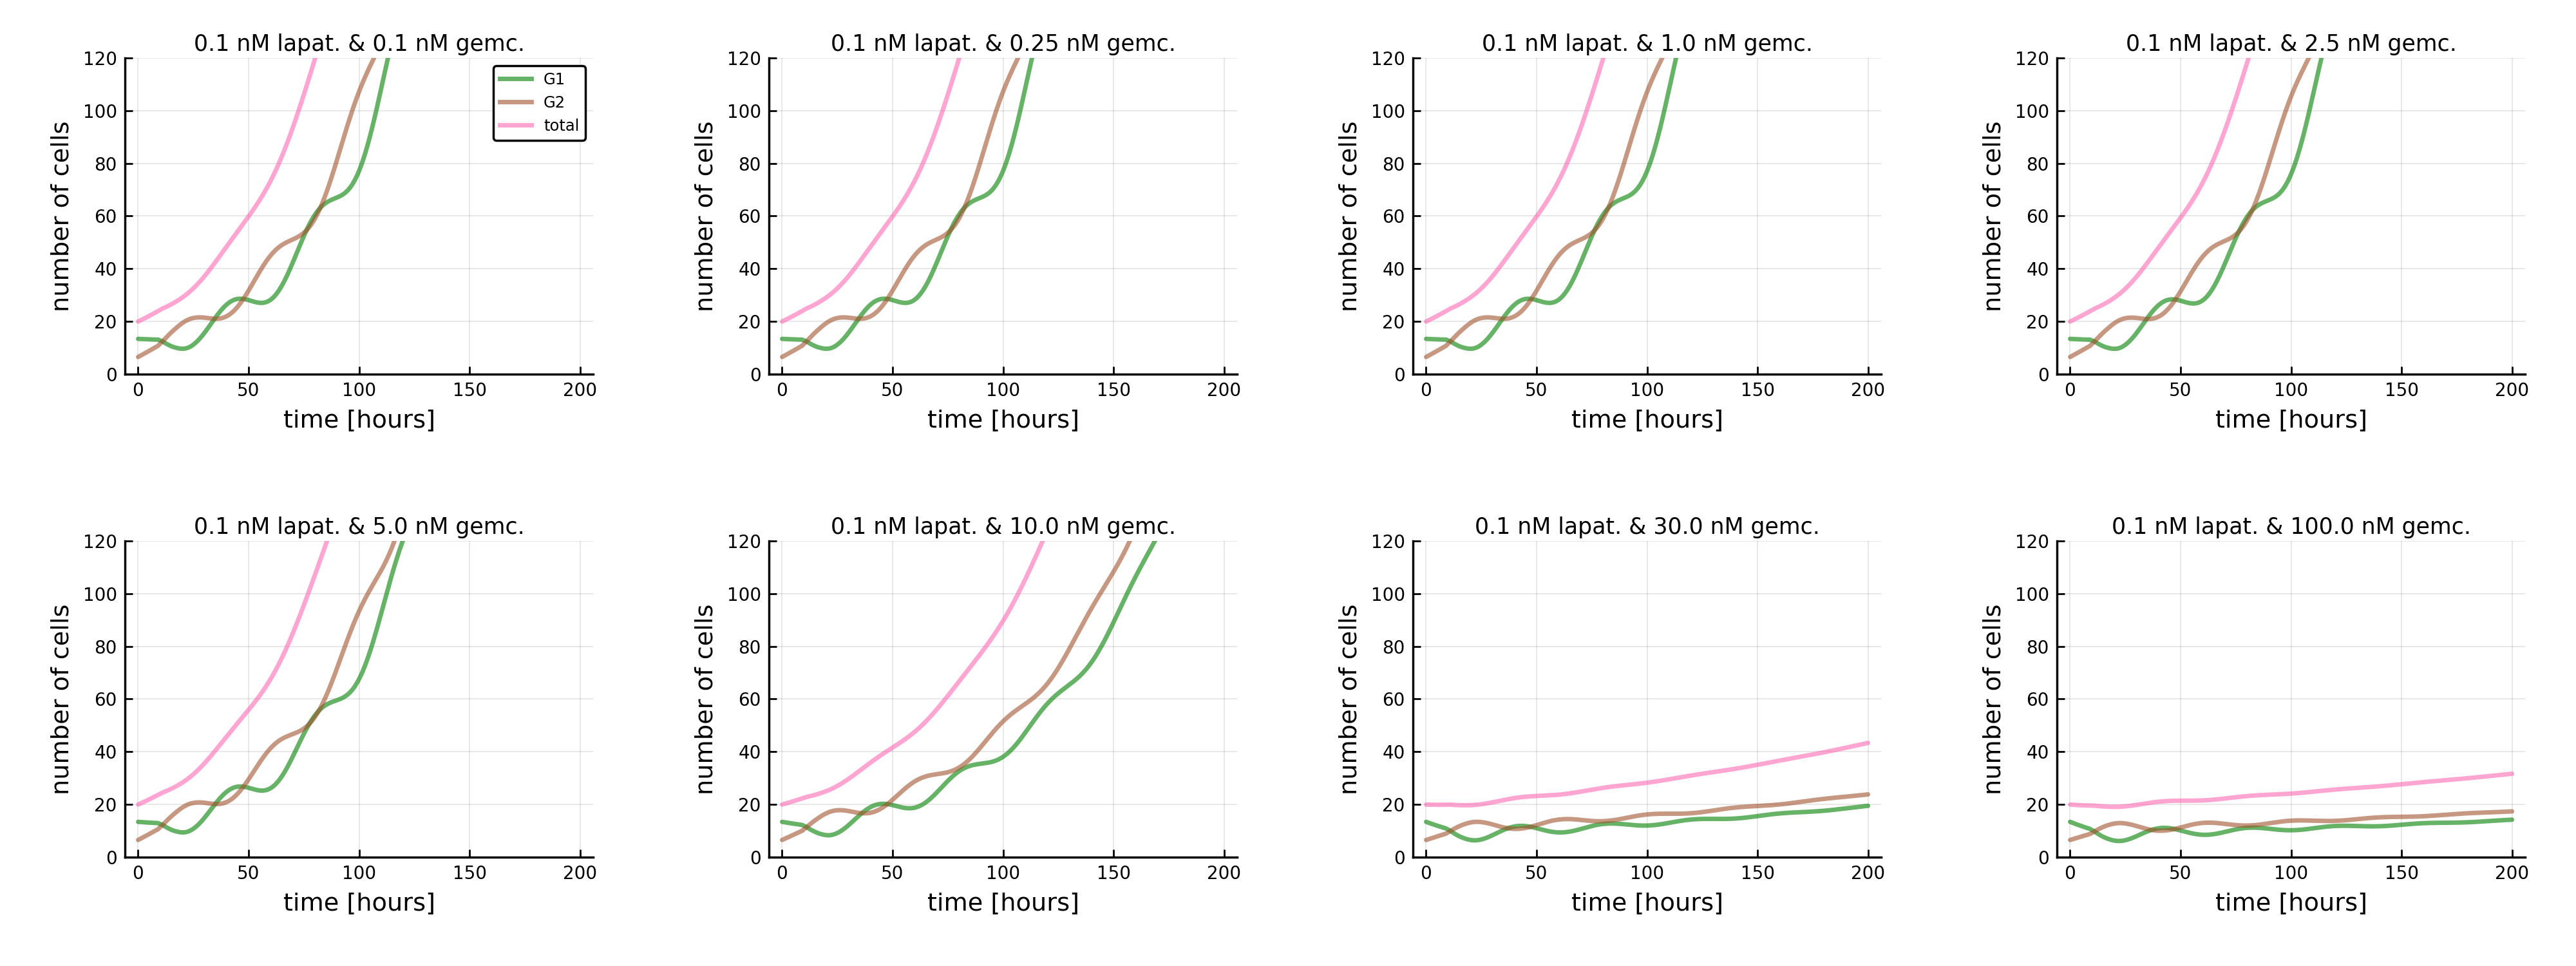

In [84]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 1, conc_l,conc_g)

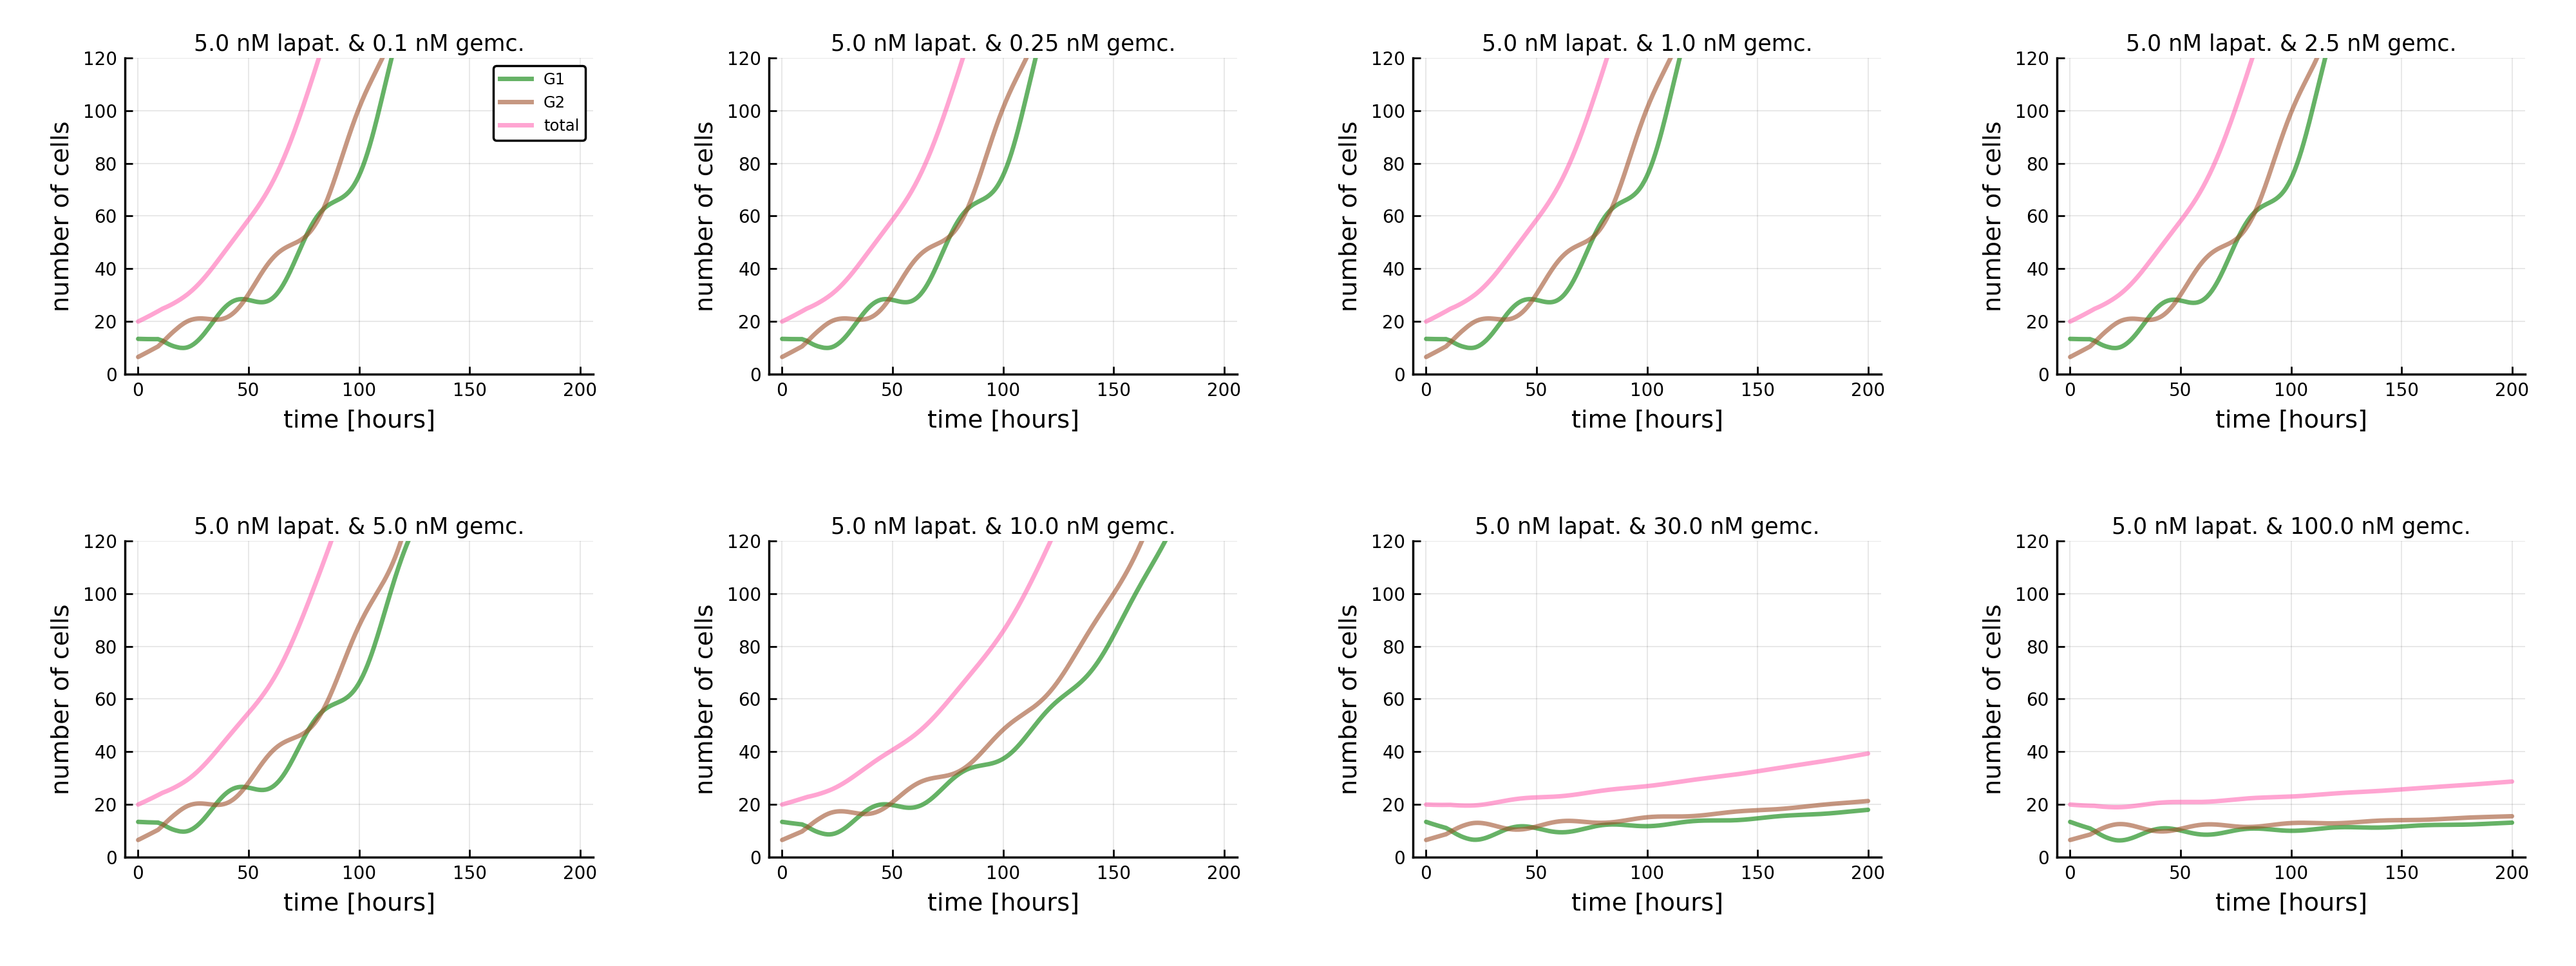

In [85]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 2, conc_l,conc_g)

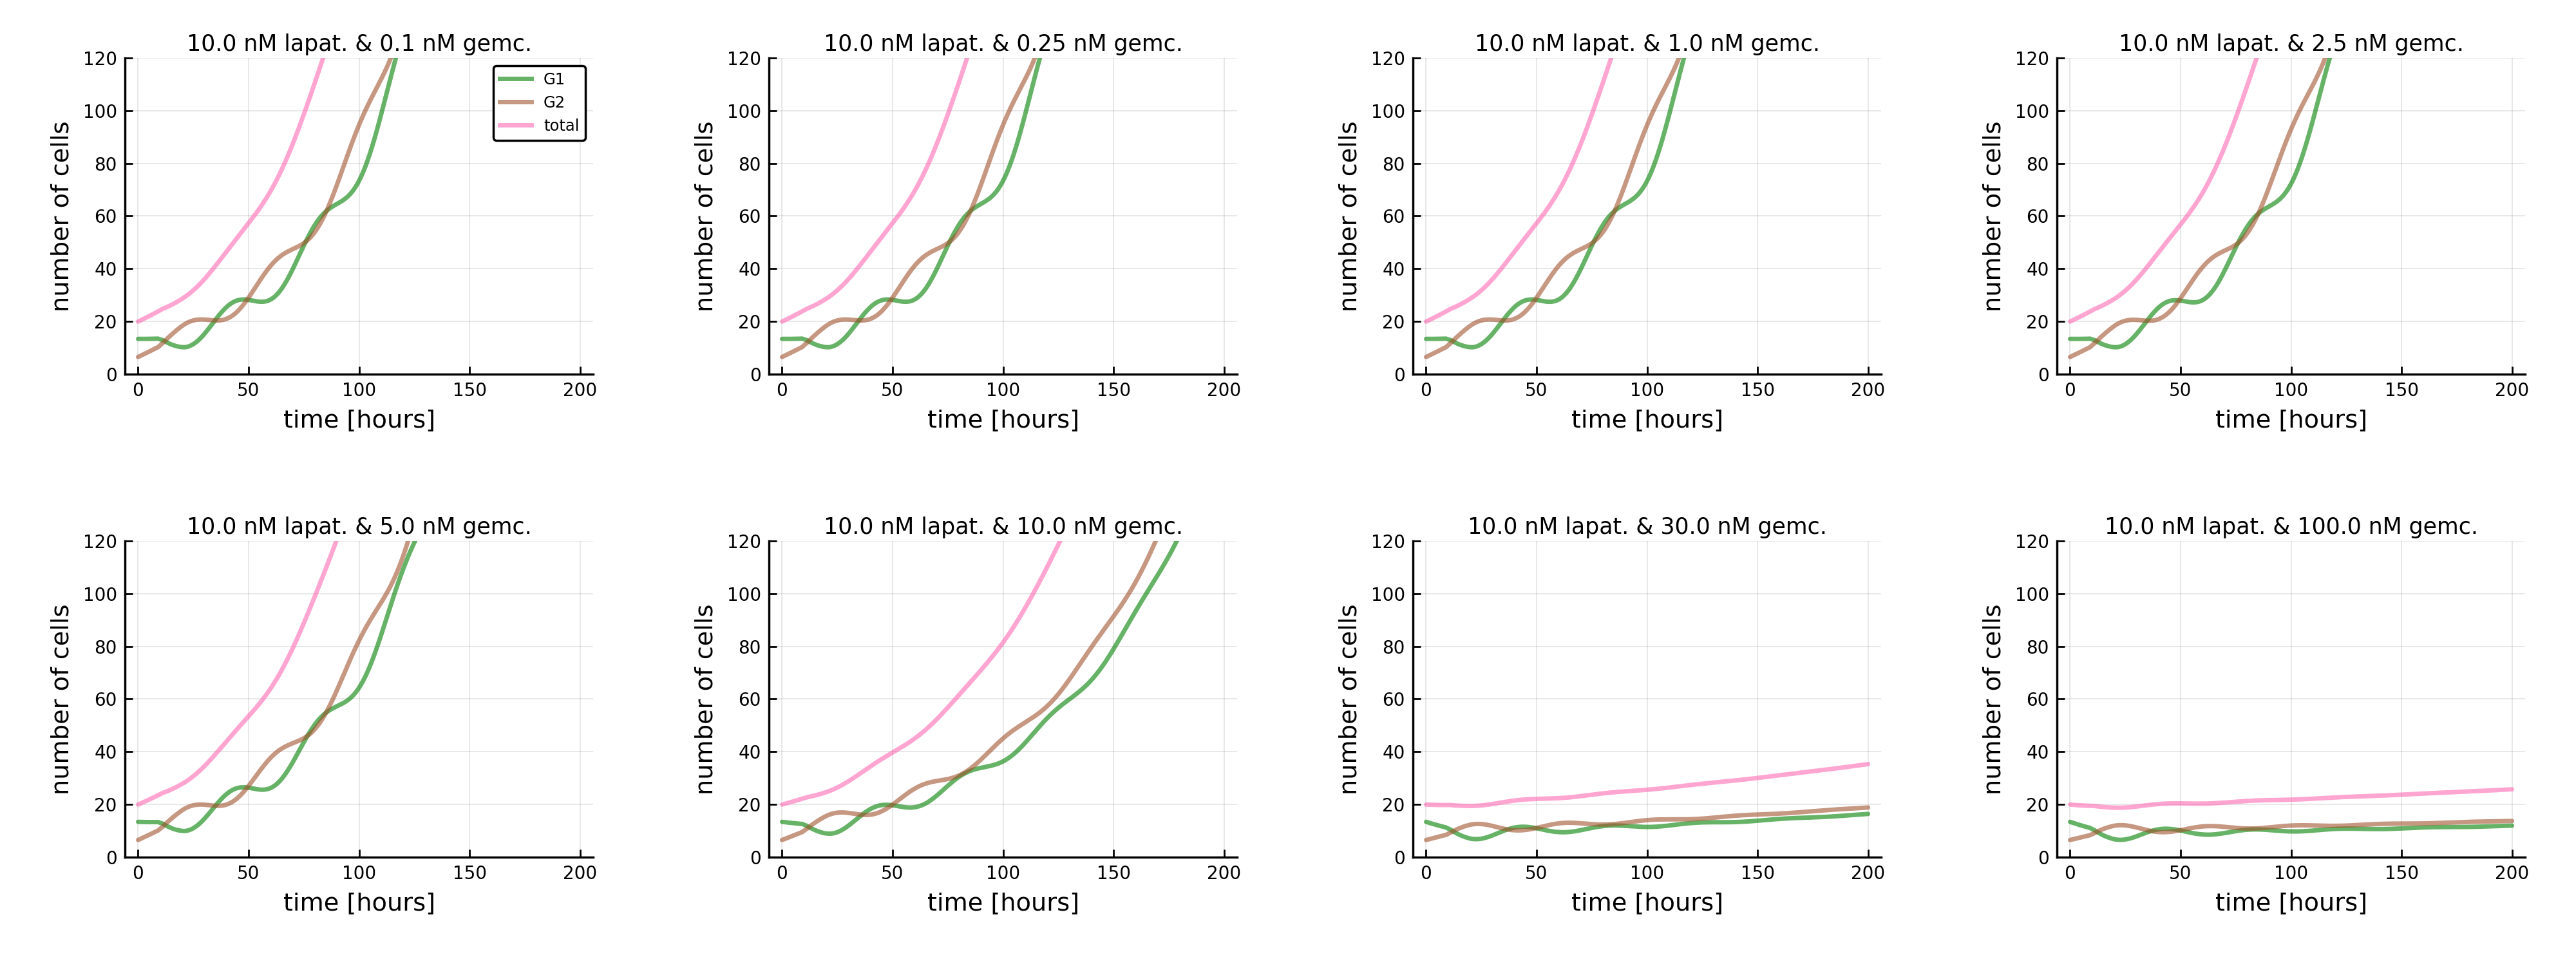

In [86]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 3, conc_l,conc_g)

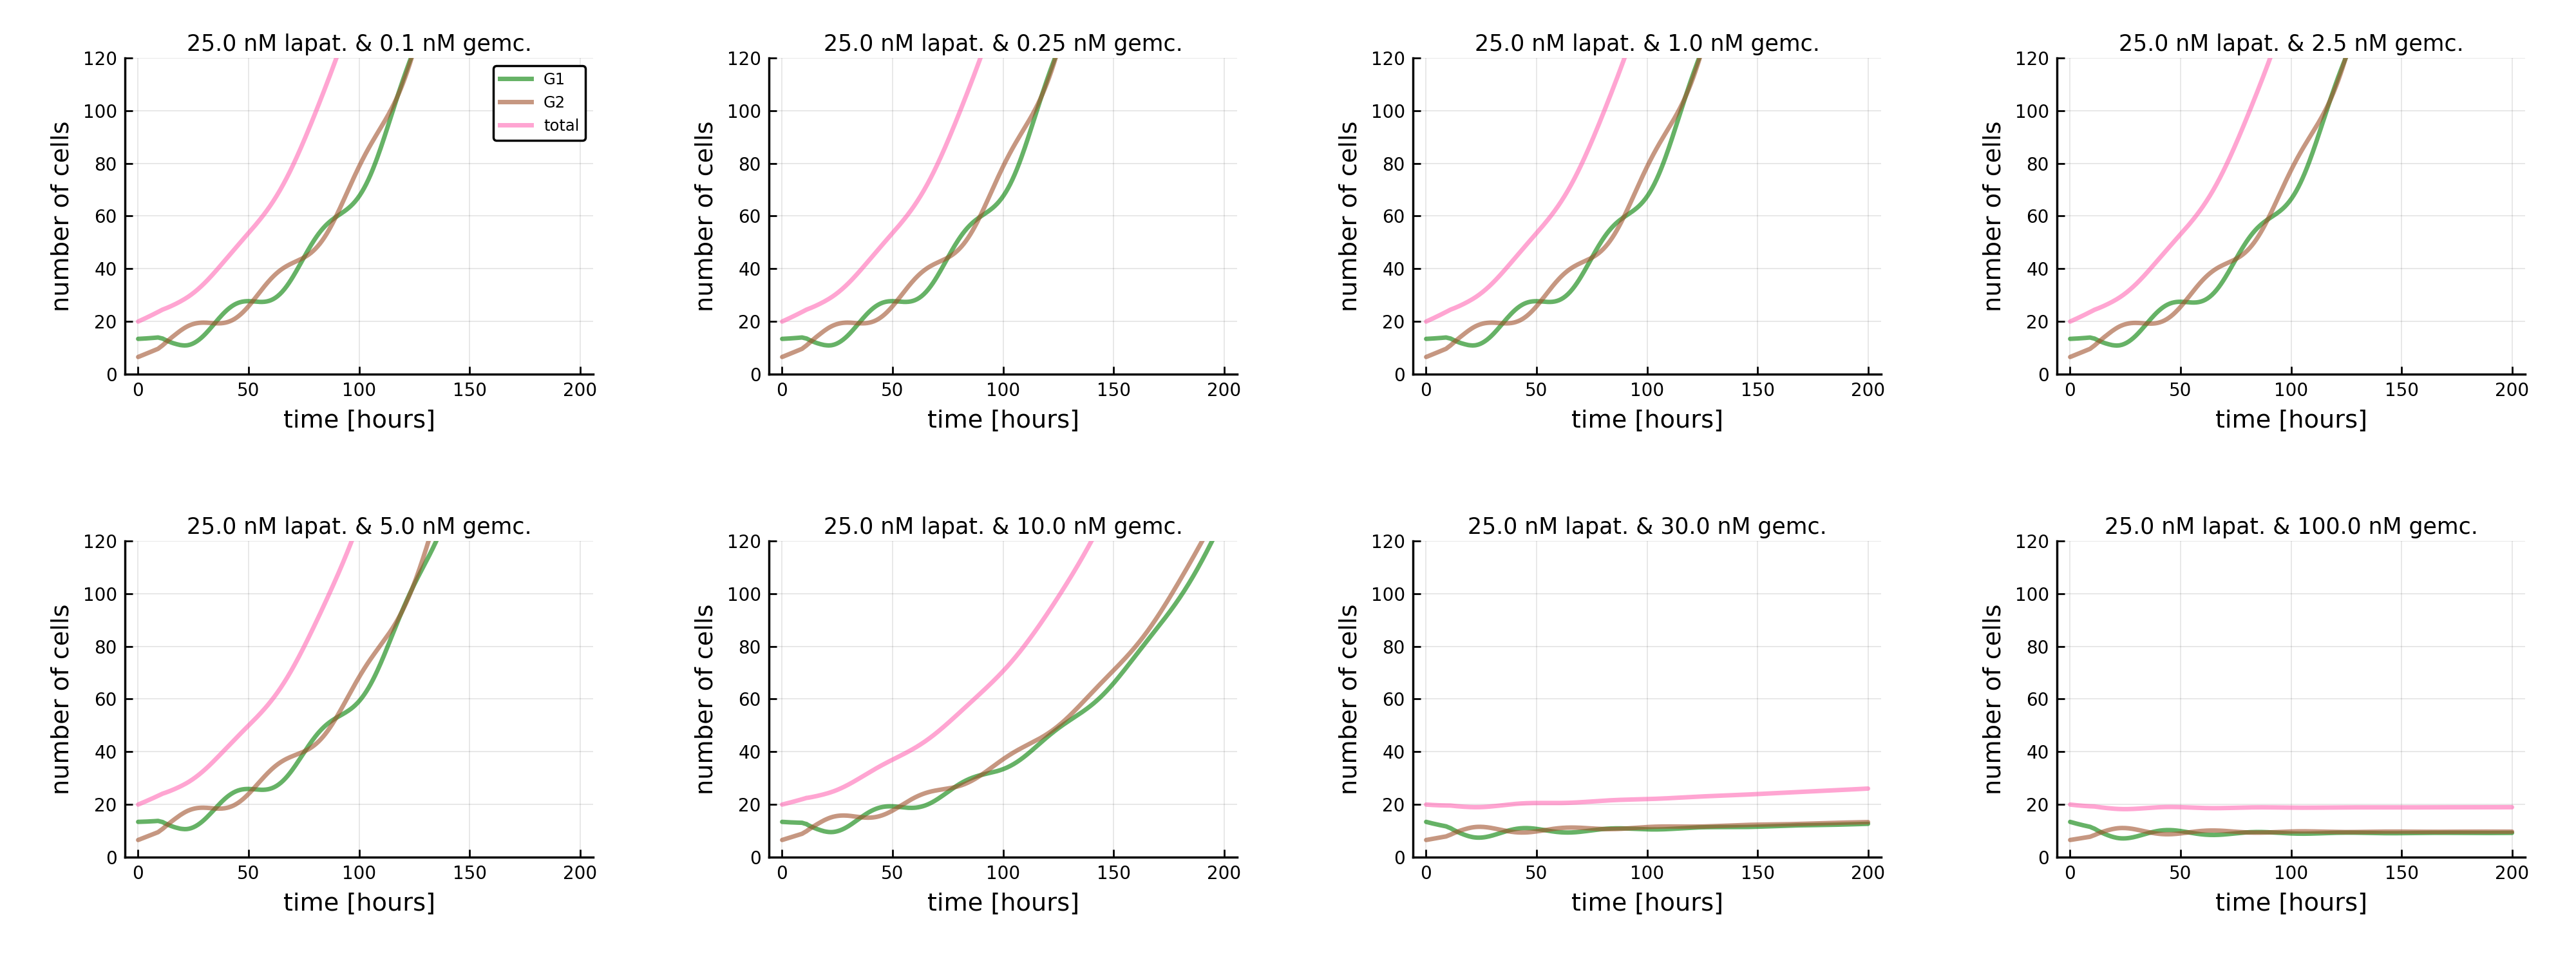

In [87]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 4, conc_l,conc_g)

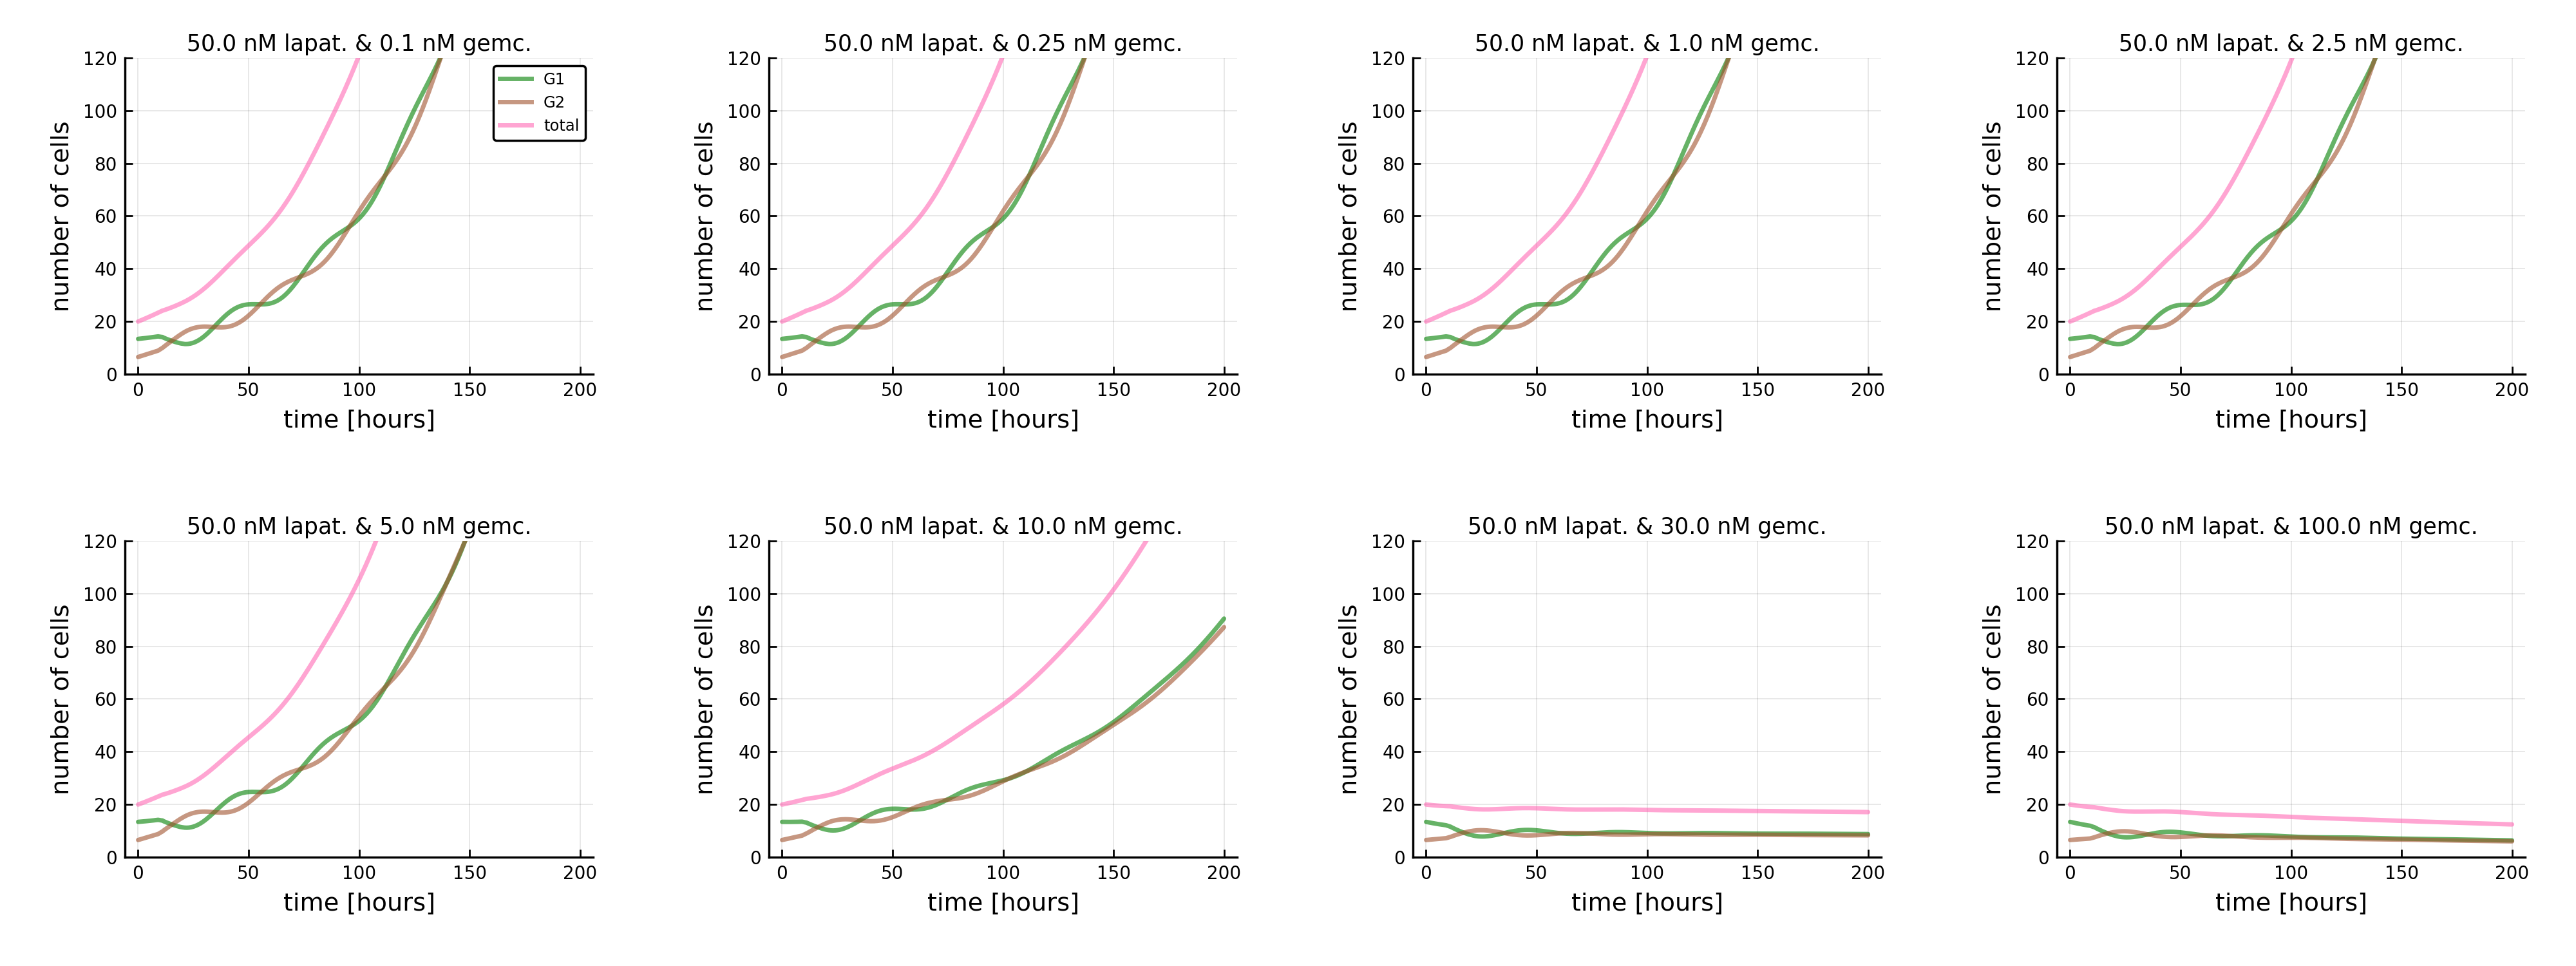

In [88]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 5, conc_l,conc_g)

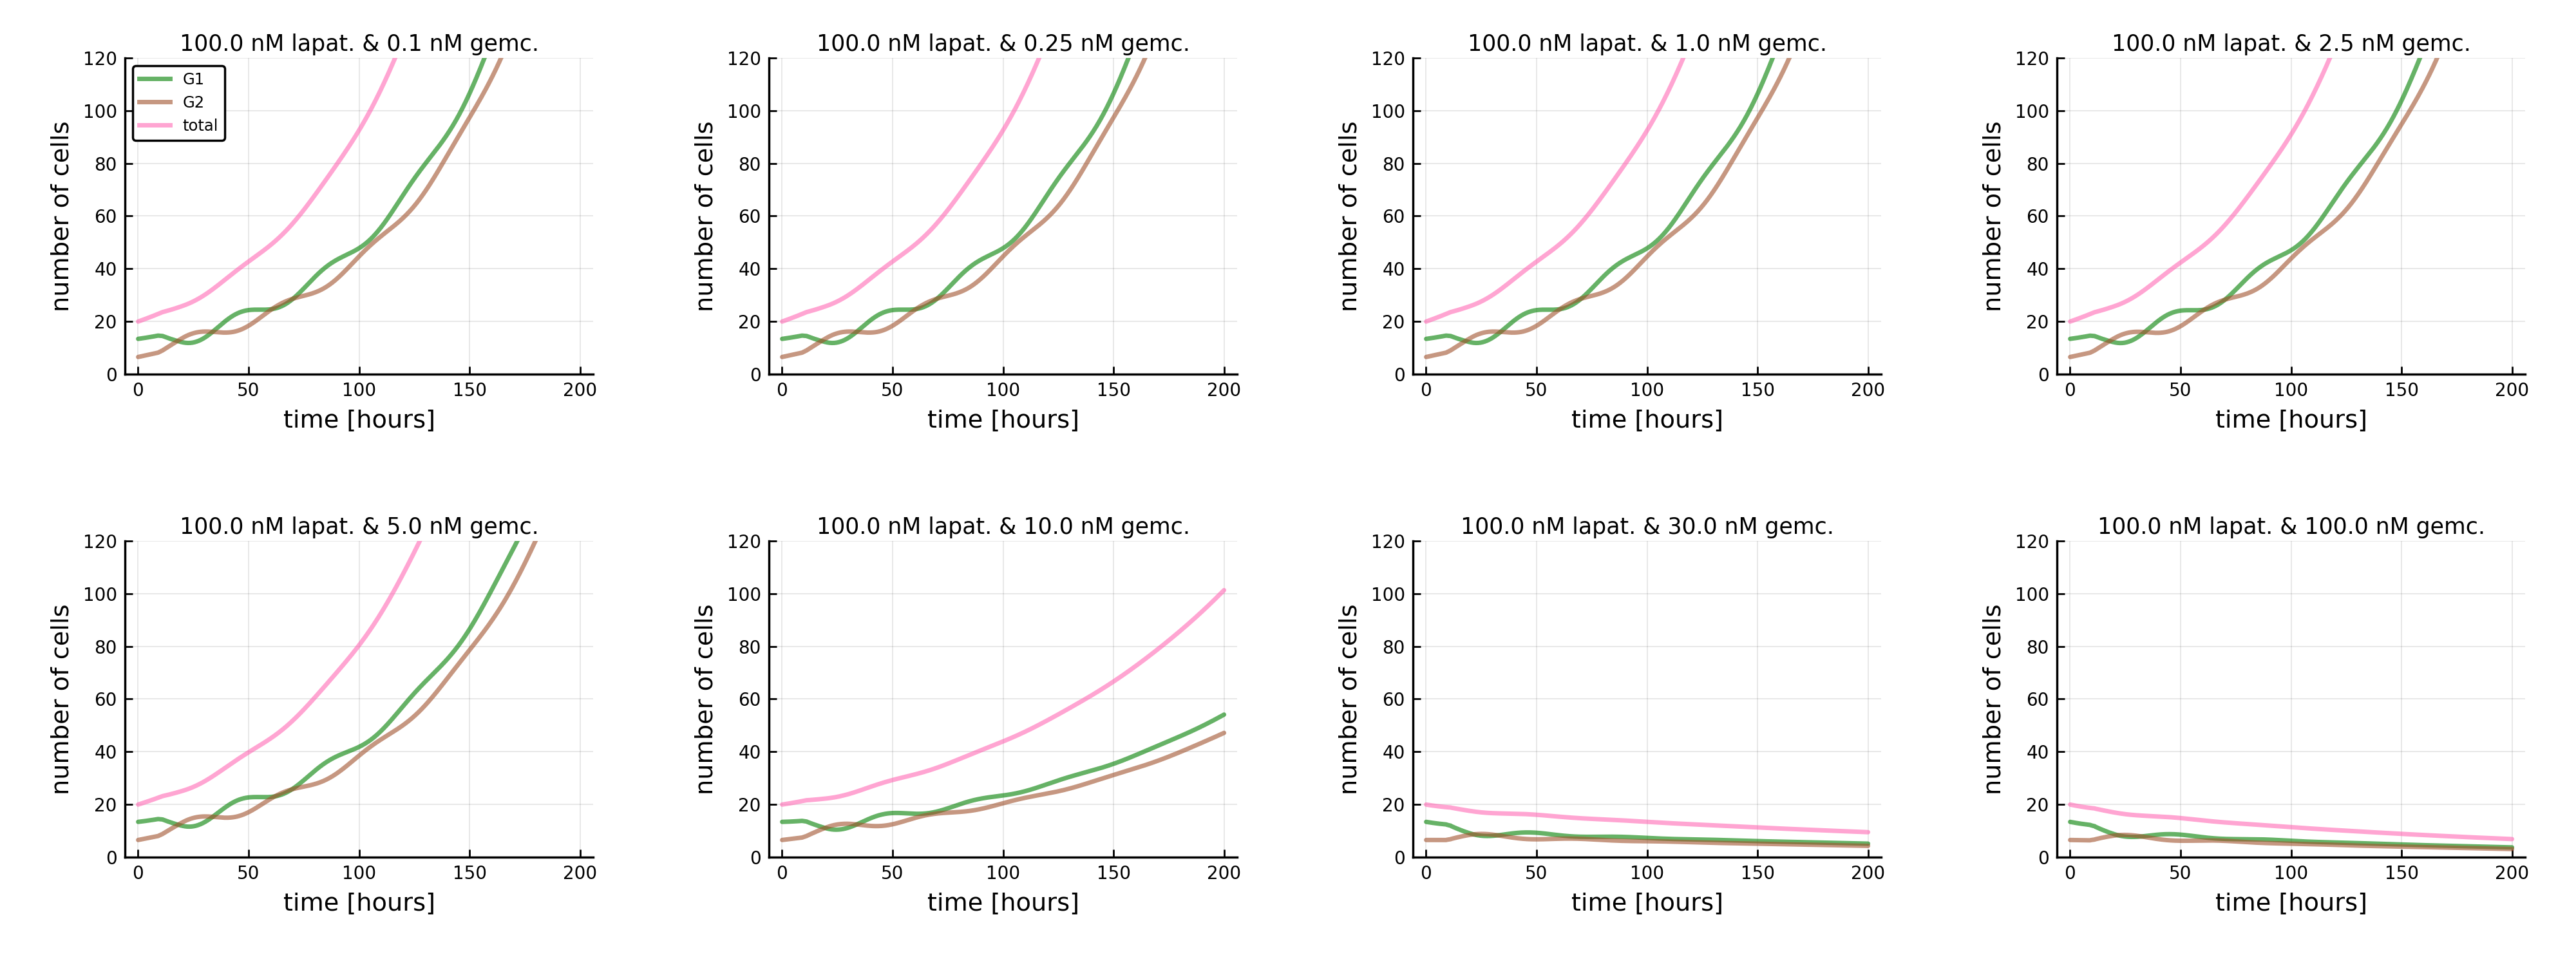

In [89]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 6, conc_l,conc_g)

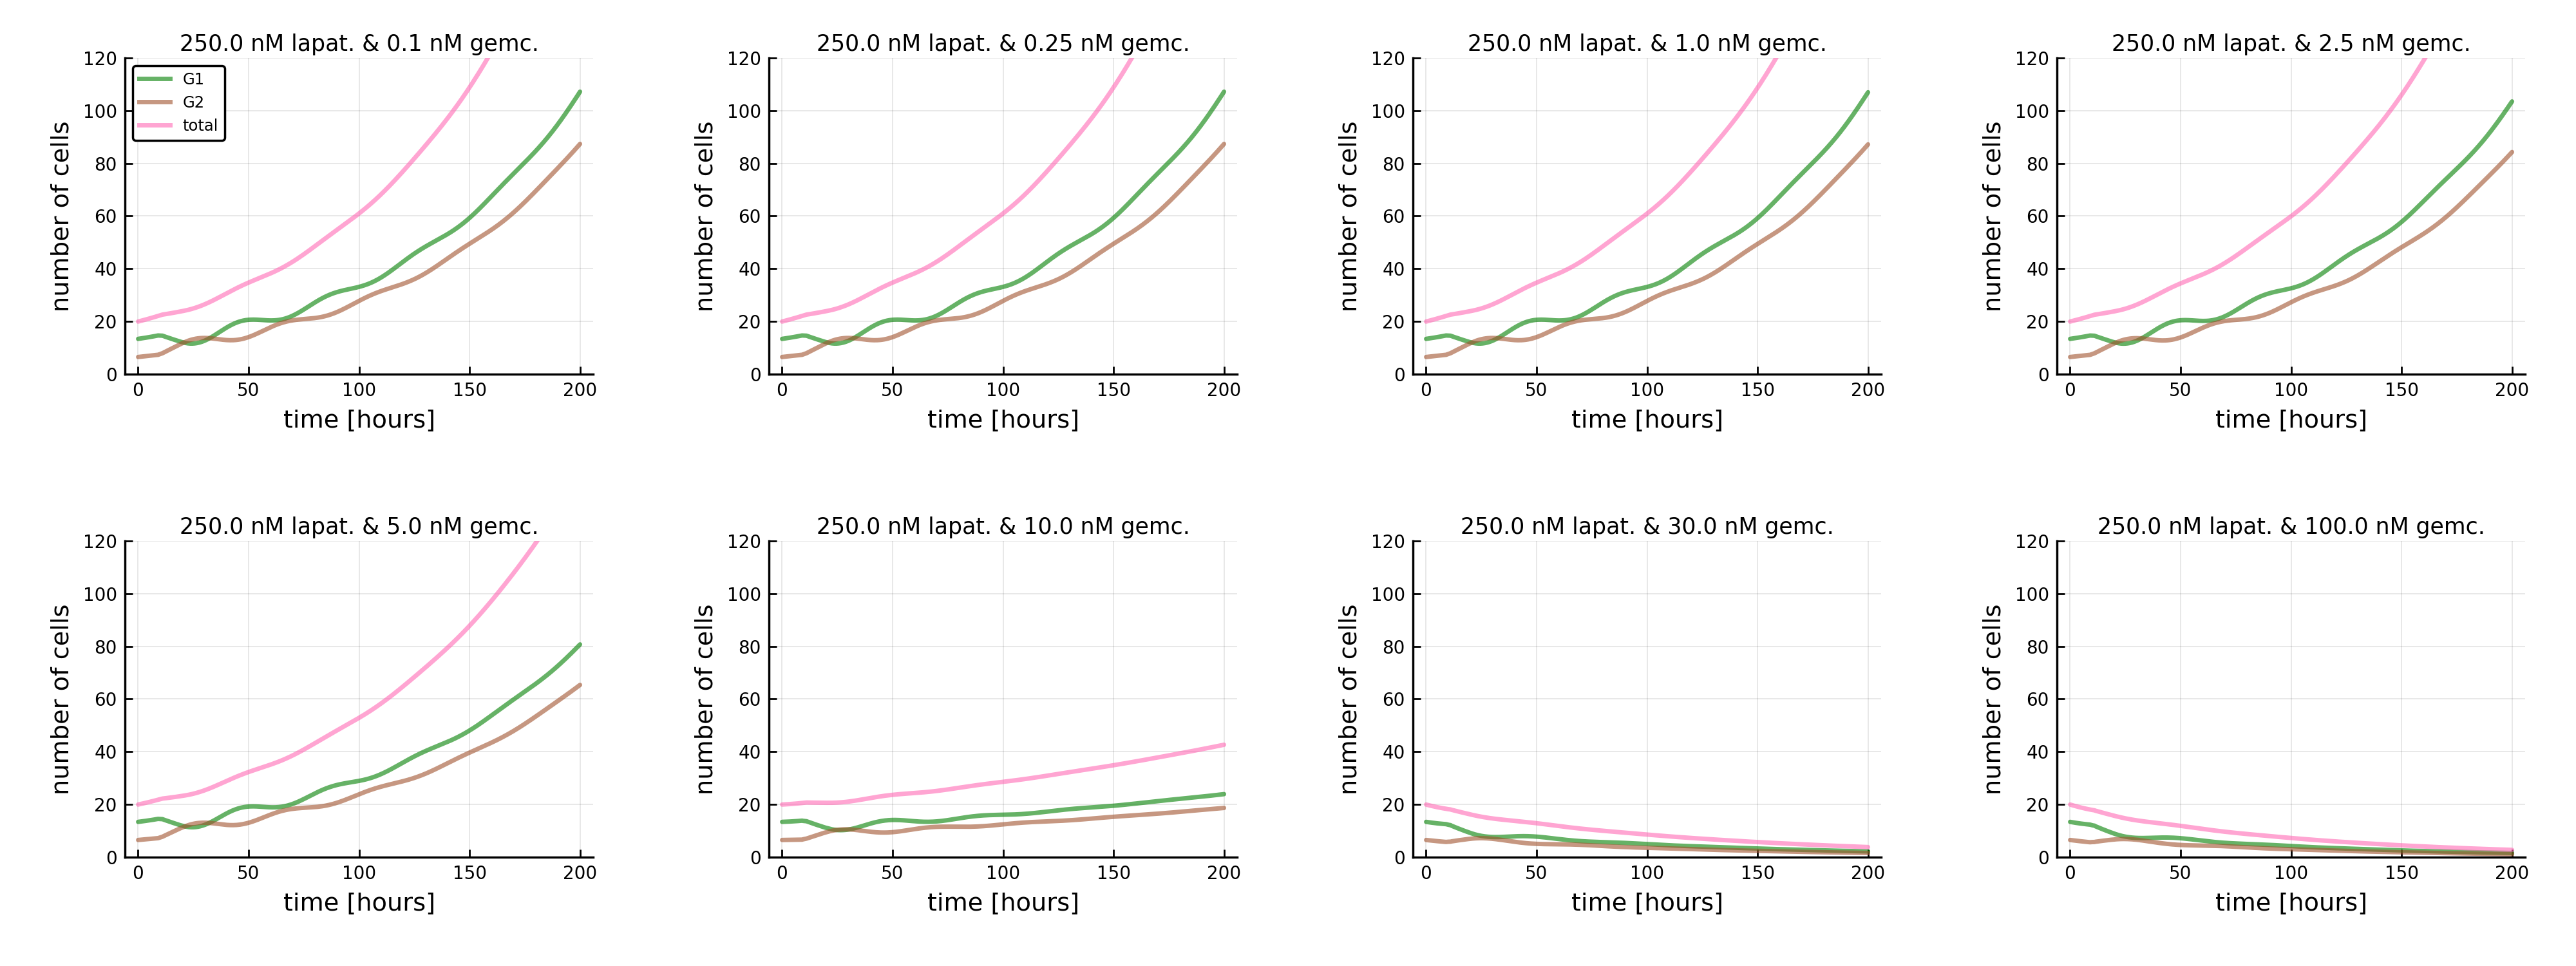

In [90]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 7, conc_l,conc_g)

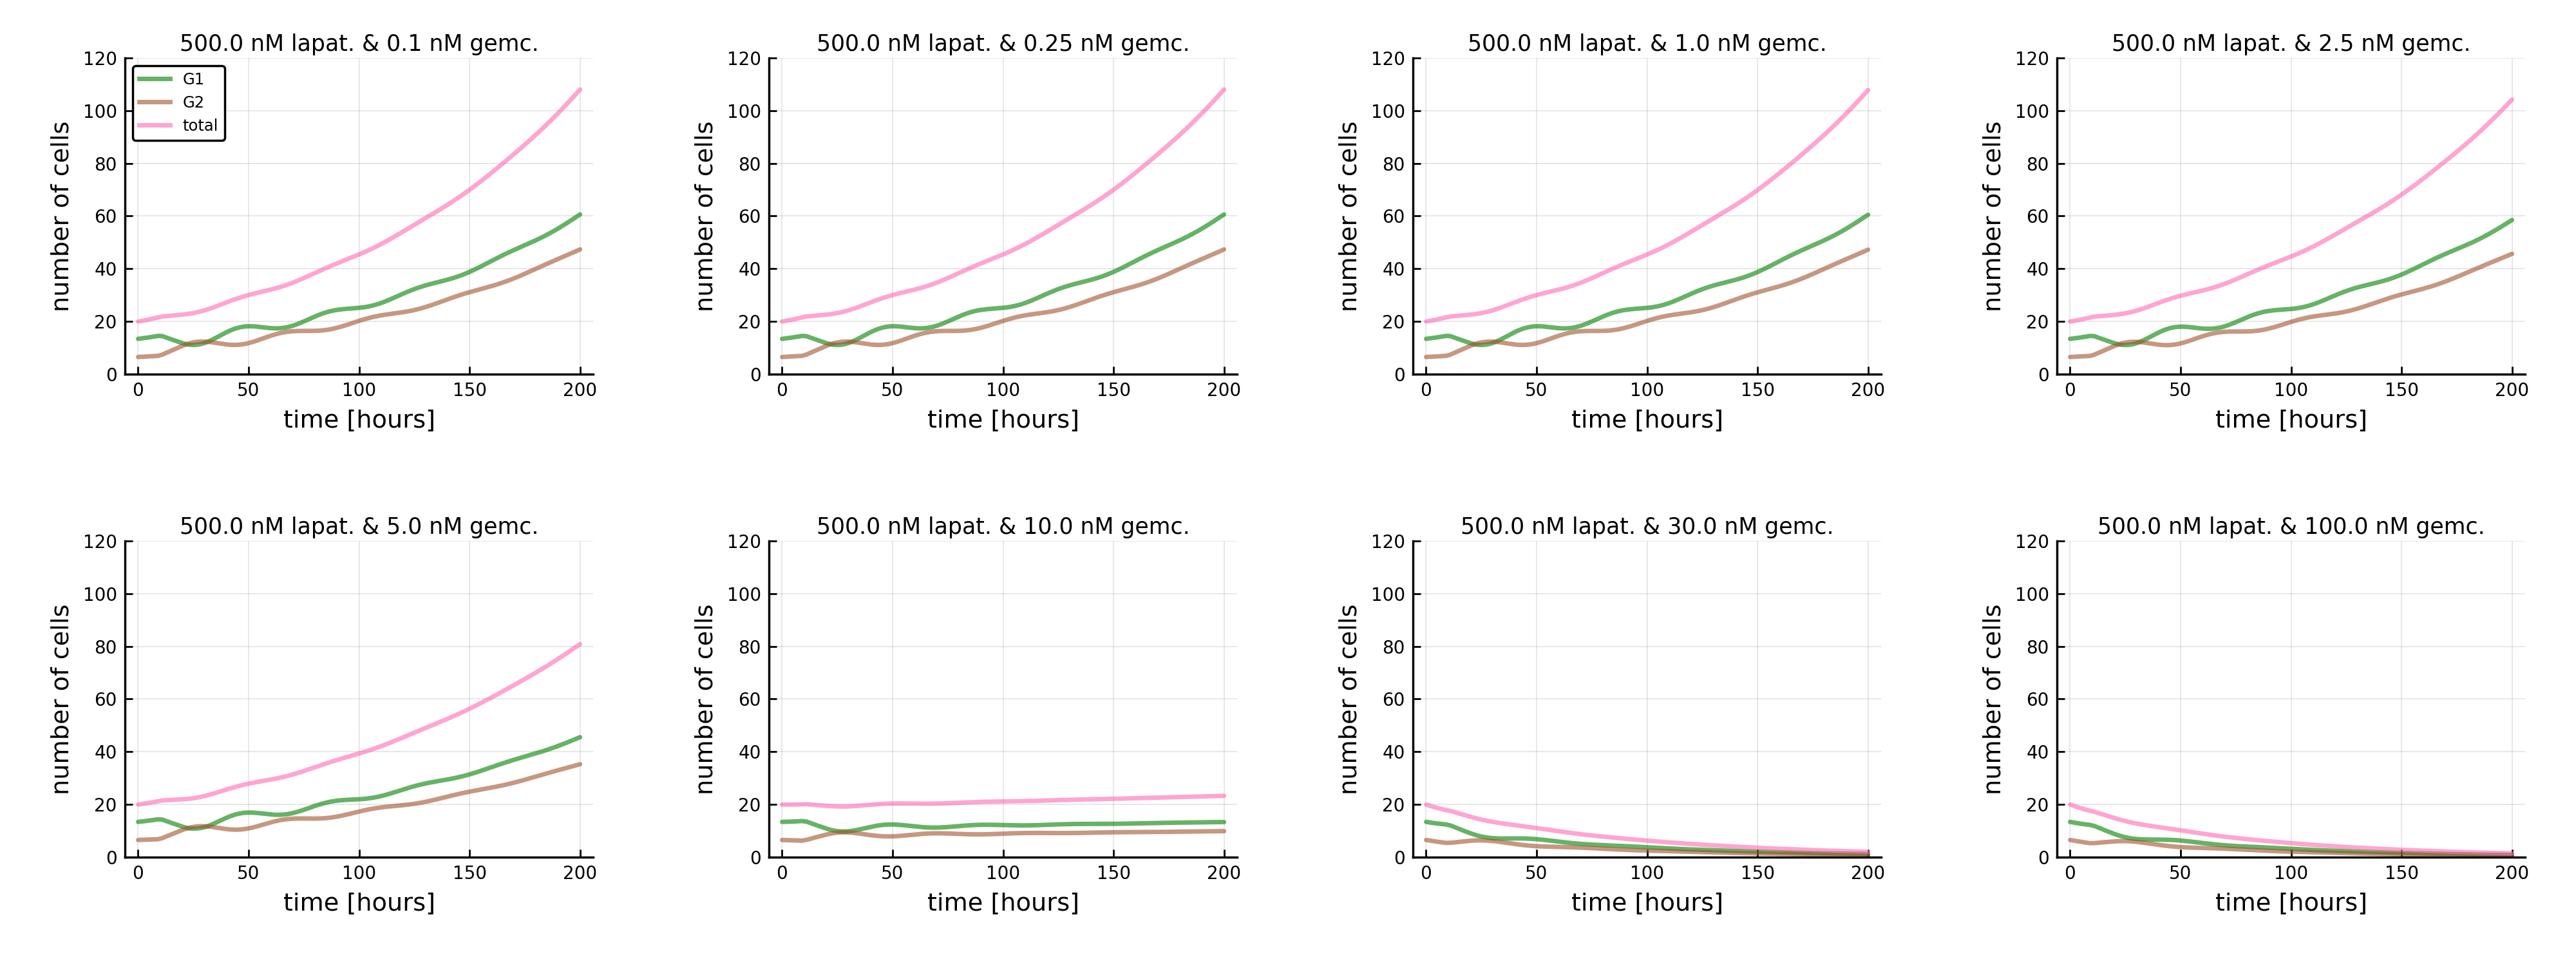

In [91]:
plot4combin(ddeparam, g2_l, g1_l, g2_0_l, g1_0_l, 8, conc_l,conc_g)